In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import matplotlib.cm as cm
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix
%matplotlib inline

# Reading data

In [12]:
df = pd.read_csv('C:\\Users\\Parto Shahvandi\\Desktop\\Customer.csv')
le = preprocessing.LabelEncoder()
le.fit(['Male', 'Female'])
df['Gender Label'] = le.transform(df['Gender'])
my_features = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values
print(type(my_features))
Scaler = MinMaxScaler()
feat_mtx = Scaler.fit_transform(my_features)
dist_mtx = distance_matrix(feat_mtx,feat_mtx)
condensed_dist = pdist(feat_mtx, metric='euclidean')
print(df.shape)
df.head()

<class 'numpy.ndarray'>
(200, 6)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Gender Label
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


# Plot data to get a first impression

Text(0.5, 1.0, 'first look at the data')

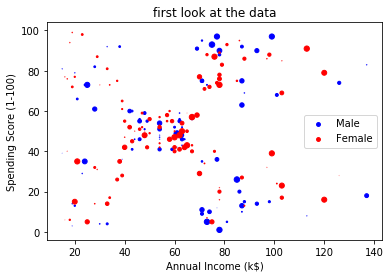

In [9]:
ax = df[df['Gender'] == 'Male'].plot(kind='scatter', x='Annual Income (k$)', y='Spending Score (1-100)',s = 30*feat_mtx[:, 0]**2, color='Blue', label='Male');
df[df['Gender'] == 'Female'].plot(kind='scatter', x='Annual Income (k$)', y='Spending Score (1-100)',s = 30*feat_mtx[:, 0]**2 , color='Red', label='Female', ax=ax);
plt.title('first look at the data')

# K-Means Method

In [13]:
cluster_num = 3
k_means = KMeans(init = "k-means++", n_clusters = cluster_num, n_init = 12)
k_means.fit(feat_mtx)
labels = k_means.labels_
df['kmeans'] = labels
kmeans_df = df.groupby('kmeans').mean()[['Age','Annual Income (k$)','Spending Score (1-100)']]
kmeans_df['Value count'] = df['kmeans'].value_counts()
kmeans_df

,Age,Annual Income (k$),Spending Score (1-100),Value count
kmeans,,,,
0,53.417910,46.955224,39.820896,67
1,28.457447,60.244681,70.446809,94
2,38.871795,84.692308,19.230769,39


# Plot K-Means

Text(0.5, 1.0, 'K-Means')

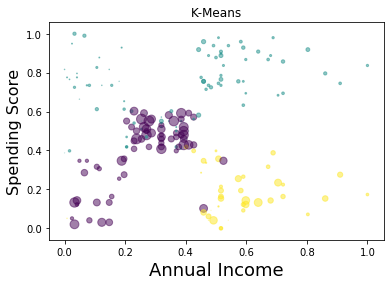

In [14]:
plt.scatter(feat_mtx[:, 1], feat_mtx[:, 2], s= 100 * ( feat_mtx[:, 0])**2  , c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Annual Income', fontsize=18)
plt.ylabel('Spending Score', fontsize=16)
plt.title('K-Means')

# Hierarchical

In [19]:
Z = hierarchy.linkage(condensed_dist, 'complete')
agglom = AgglomerativeClustering(n_clusters = 3, linkage = 'complete', affinity='precomputed')
agglom.fit(dist_mtx)
df['cluster_'] = agglom.labels_
agg_customer = df.groupby(['cluster_','Gender'])['Age', 'Annual Income (k$)', 'Spending Score (1-100)'].mean()
agg_customer['Cluster count'] = df.groupby(['cluster_','Gender'])['cluster_'].count()
agg_customer

Age  Annual Income (k$)  Spending Score (1-100)  \
cluster_ Gender                                                          
0        Female  34.172414           90.344828               66.172414   
         Male    32.413793           87.965517               54.689655   
1        Female  28.159091           44.136364               54.886364   
         Male    25.720000           40.400000               59.000000   
2        Female  52.230769           53.179487               36.846154   
         Male    56.470588           56.323529               35.529412   

                 Cluster count  
cluster_ Gender                 
0        Female             29  
         Male               29  
1        Female             44  
         Male               25  
2        Female             39  
         Male               34

# Dendrogram

Text(0.5, 1.0, 'Hierarchical Clustering dendrogram')

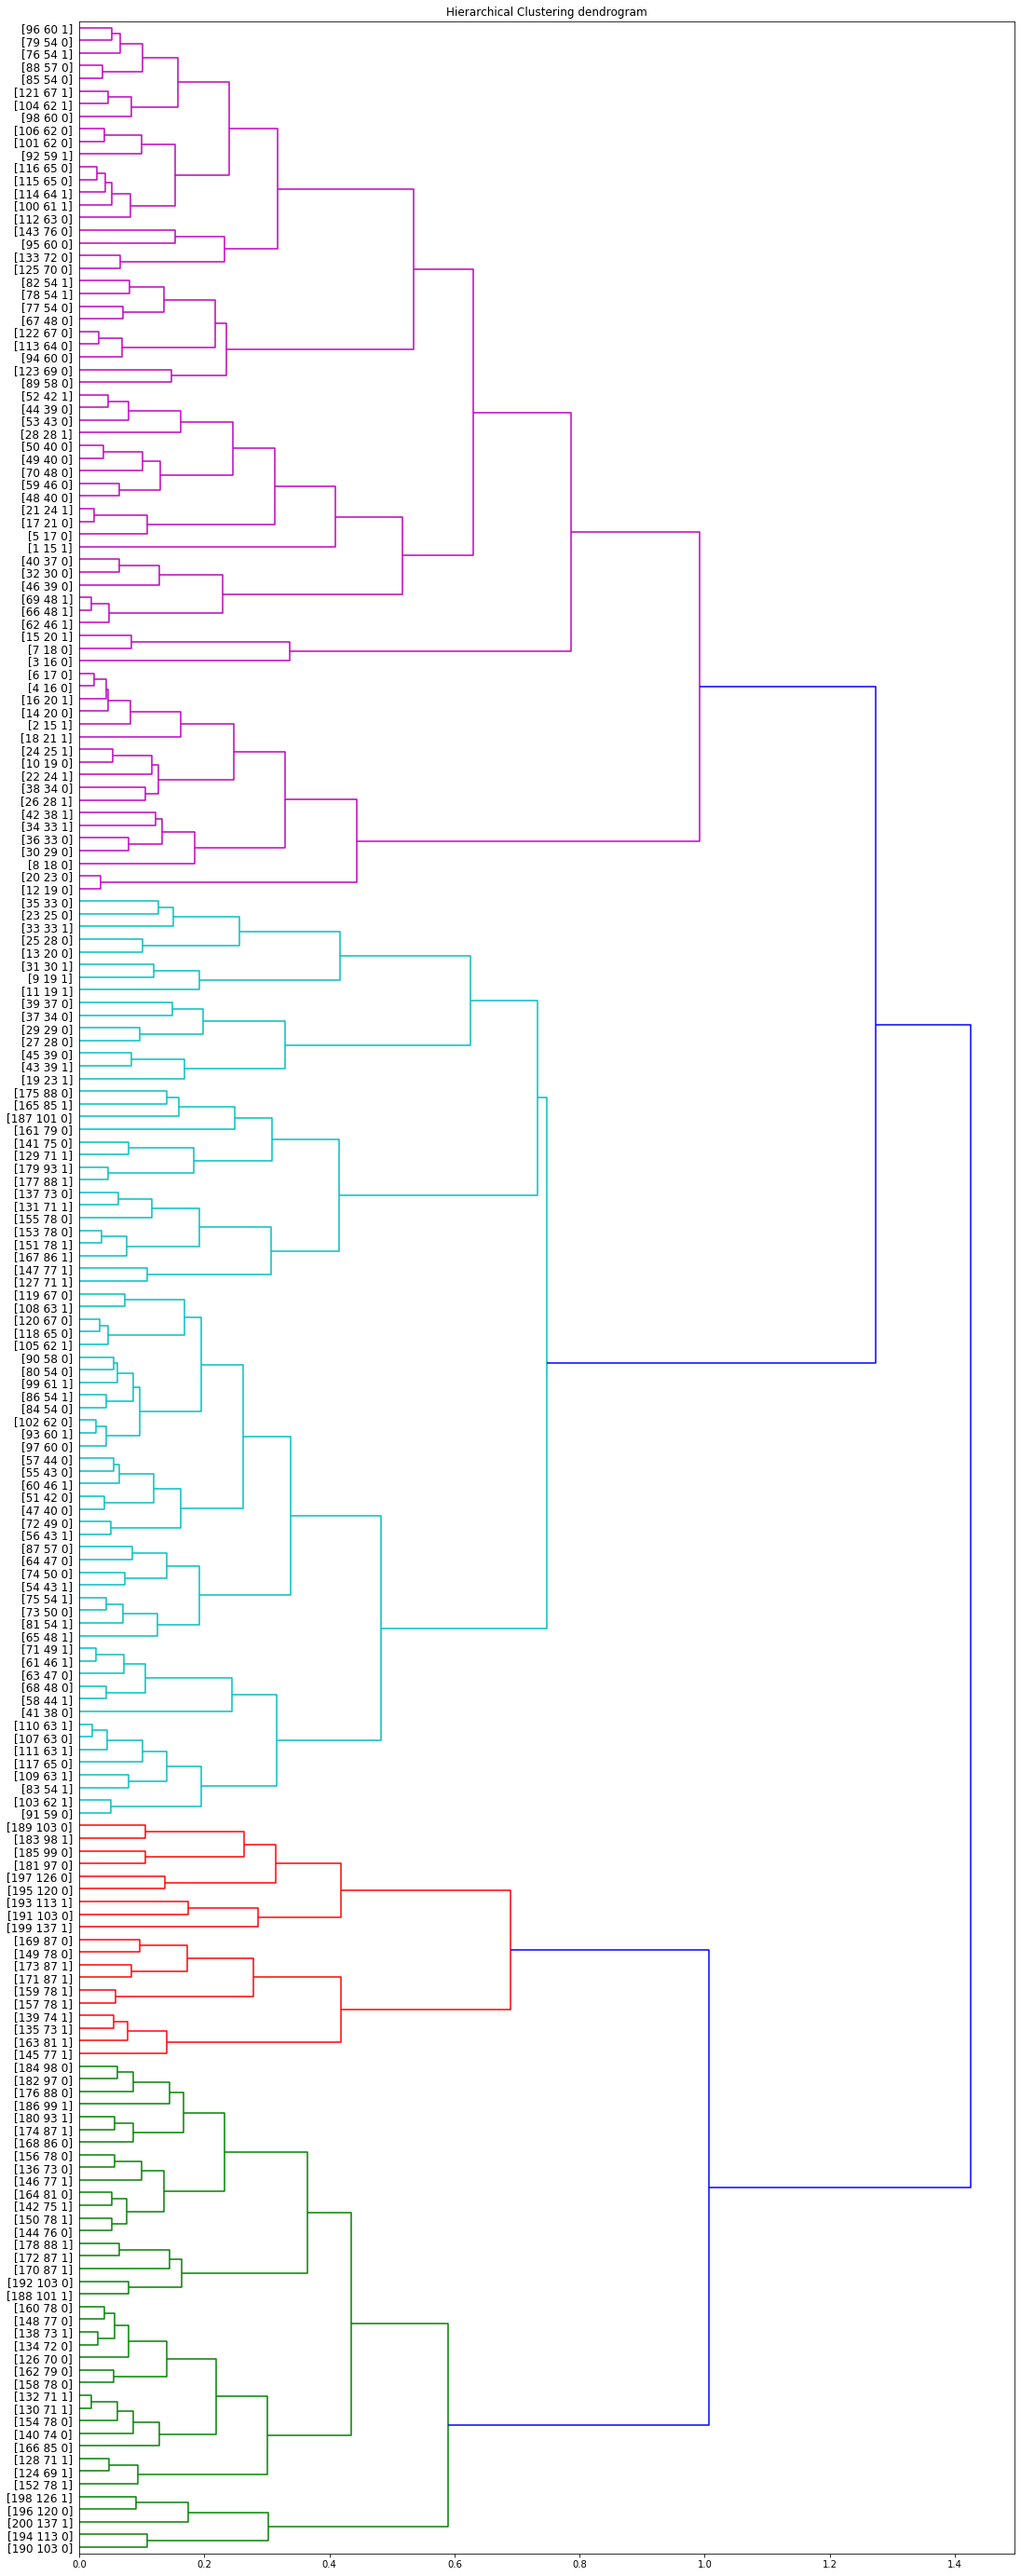

In [20]:
fig = pylab.figure(figsize=(18, 50))
def llf(id):
    return '[%s %s %s]' % (df['CustomerID'][id], df['Annual Income (k$)'][id], int(float(df['Gender Label'][id])))


dendro = hierarchy.dendrogram(Z, leaf_label_func=llf, leaf_rotation=0, leaf_font_size=12, orientation='right')
pylab.title('Hierarchical Clustering dendrogram')

# Aggromative Plot

Text(0, 0.5, 'Age')

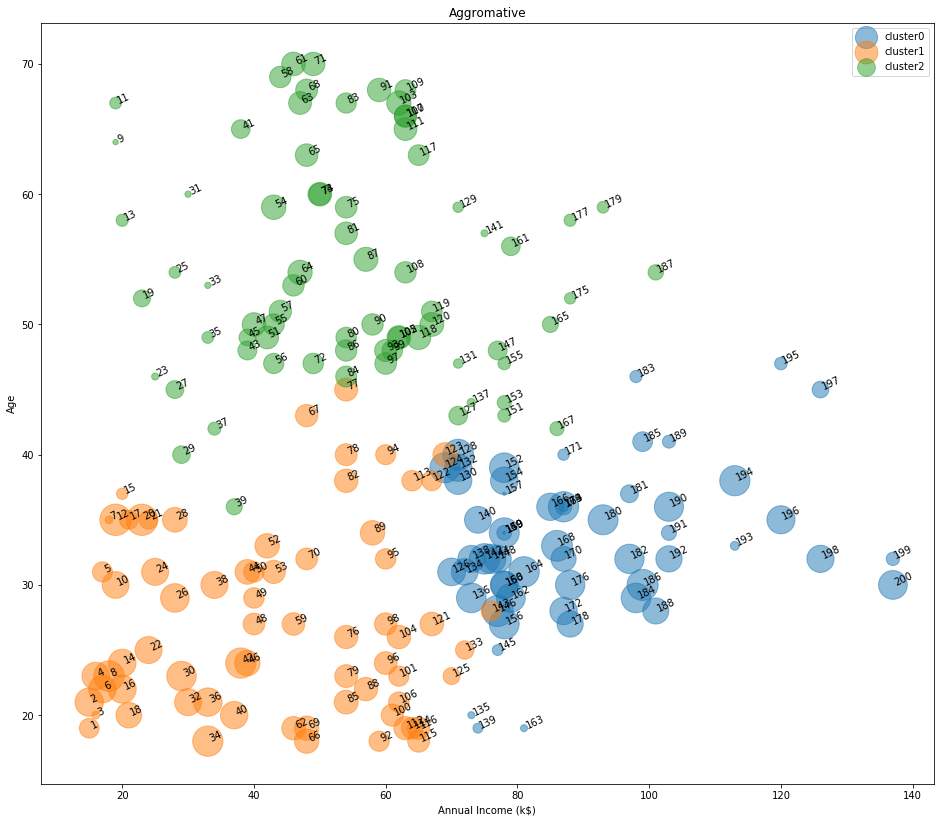

In [21]:
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(16,14))

for label in cluster_labels:
    subset = df[df.cluster_ == label]
    subset.columns = ['CustomerID','Gender','Age','Income','Score','Gender_Lable','Cluster','Kmeans']
    for i in subset.index:
            plt.text(subset.Income[i], subset.Age[i],int(subset['CustomerID'][i]), rotation=25)
    plt.scatter(subset.Income, subset.Age, s= subset.Score*10, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Aggromative')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Age')


# DBSCAN

In [22]:
eps = 0.15
min_samples = 5
db = DBSCAN(eps=eps,min_samples=min_samples,metric='euclidean')
db.fit(feat_mtx)
# print(set(db.labels_))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
# print(n_clusters_)
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(db.labels_))))
df['DBSCAN'] = db.labels_
df['DBSCAN'].value_counts()

 0    135
 2     36
-1     24
 1      5
Name: DBSCAN, dtype: int64

# Plot DBSCAN

Text(0.5, 1.0, 'DBSCAN')

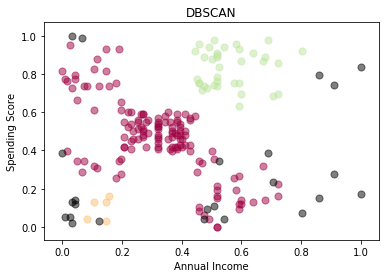

In [27]:
fig = plt.figure()
ax = fig.add_subplot()
for k, col in zip(set(db.labels_), colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (db.labels_ == k)

    # Plot the datapoints that are clustered
    xy = feat_mtx[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 1], xy[:, 2],s=50, c=[col], marker=u'o', alpha=0.5)

    # Plot the outliers
    xy = feat_mtx[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 1], xy[:, 2],s=50, c=[col], marker=u'o', alpha=0.5)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('DBSCAN')